In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [4]:
first_trial_multi = pd.read_csv("first_multi_trial.csv")

In [5]:
first_trial_multi.cluster_id.value_counts()

casual_subs            82953
current_affair_subs    12016
executive_subs          1926
Name: cluster_id, dtype: int64

In [3]:
first_trial_multi.cluster_id.value_counts()

casual_subs            82953
current_affair_subs    12016
executive_subs          1926
Name: cluster_id, dtype: int64

In [5]:
# fill any Nulls with 0

first_trial_multi.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in first_trial_multi.columns if 'other' in x] + ['subscription_status']

first_trial_multi = first_trial_multi.drop(cols_to_drop, 
                                           axis=1)

In [9]:
X = first_trial_multi.iloc[:, :-1]
y = first_trial_multi["cluster_id"]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
# split the data in training and remaining dataset
SEED = 32
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y, 
                                                  train_size=0.7, 
                                                  stratify = y,
                                                  random_state = SEED 
                                                 )


# make test and val sets
X_val, X_test, y_val, y_test = train_test_split(X_rem,
                                                y_rem, 
                                                test_size=0.5,
                                                stratify = y_rem,
                                                random_state = SEED 
                                                )

In [25]:
print("--- Train set ---", X_train.shape, y_train.shape, round(X_train.shape[0]/first_trial_multi.shape[0], 2))

print("--- Val set ---", X_val.shape, y_val.shape, round(X_val.shape[0]/first_trial_multi.shape[0], 2))

print("--- Test set ---", X_test.shape, y_test.shape, round(X_test.shape[0]/first_trial_multi.shape[0], 2))

--- Train set --- (354773, 560) (354773,) 0.7
--- Val set --- (76023, 560) (76023,) 0.15
--- Test set --- (76023, 560) (76023,) 0.15


In [22]:
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     StratifiedKFold,
                                     StratifiedShuffleSplit
                                    )

                                    
from sklearn.metrics import (classification_report, 
                             plot_confusion_matrix
                            )
scoring='f1_weighted'

skf = StratifiedKFold(n_splits = 10, 
                      shuffle=True,
                      random_state = SEED)

In [23]:
y_val.shape

(76023,)

In [27]:
dummy_strategies = ['stratified', 'uniform', 'most_frequent']

for item in dummy_strategies:

    dummy = DummyClassifier(strategy=item,random_state = SEED)

    dummy_score = cross_val_score(
        dummy,
        X_train,
        y_train,
        cv=skf, # using StratifiedKFold w/ shuffle=True
        n_jobs=-1,
        scoring=scoring
    )
    
    print("Strategy: ", item)
    print(dummy_score)
    print("Dummy average score is", round(np.mean(dummy_score), 2), "\n") 
    

print("Classification report for Strategy: most_frequent")

dummy_preds = [0] * 76023
print(classification_report(y_val, 
                            dummy_preds)) 

Strategy:  stratified
[0.68127945 0.68548205 0.68477918 0.68376095 0.68395511 0.68154441
 0.68458984 0.6818796  0.68196603 0.68184006]
Dummy average score is 0.68 

Strategy:  uniform
[0.34099505 0.34148452 0.33902916 0.34141187 0.33950005 0.3404636
 0.33998474 0.34123101 0.33943444 0.34190206]
Dummy average score is 0.34 

Strategy:  most_frequent
[0.72332085 0.72332085 0.72332085 0.72335251 0.72335251 0.72331336
 0.72331336 0.72331336 0.72331336 0.72335251]
Dummy average score is 0.72 

Classification report for Strategy: most_frequent
              precision    recall  f1-score   support

           0       0.16      1.00      0.28     12437
           1       0.00      0.00      0.00      1800
           2       0.00      0.00      0.00       297
           3       0.00      0.00      0.00     61489

    accuracy                           0.16     76023
   macro avg       0.04      0.25      0.07     76023
weighted avg       0.03      0.16      0.05     76023



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.9844226  0.98250319 0.98434649 0.98768606 0.98155245 0.98634516
 0.9874393  0.98772673 0.98752604 0.98740615]
LGBM base score is 0.9856954153280515


              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12437
           1       0.88      0.83      0.86      1800
           2       0.70      0.83      0.76       297
           3       0.99      1.00      0.99     61489

    accuracy                           0.98     76023
   macro avg       0.88      0.90      0.89     76023
weighted avg       0.98      0.98      0.98     76023



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


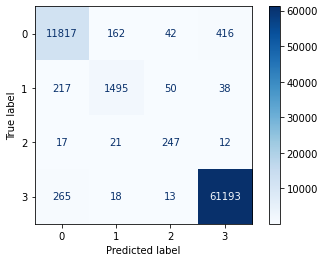

In [31]:
# using skf pipe, pred on val set

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred)) #, target_names = ['Non-subscriber', 'subscriber']
                            

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )